# Predicting Heart Disease Based On Physical Characteristics of Patients

# Introduction

Heart disease is an often-lethal condition, and being able to accurately predict if patients have it, based on easy-to-observe qualities, would allow for quicker action from doctors and better patient outcomes. So here we ask the question: is it possible to predict whether a patient has heart disease based on a set of measurable factors? To build a model that could answer this, we used the publicly-available heart disease dataset donated by the Hungarian Institute of Cardiology, the University Hospitals of Zurich and Basel, the V. A. Medical Center of Long Beach, and the Cleveland Clinic Foundation. Each row in this dataset represents a patient, and the columns store physical, health-related information about each patient — such as their age, sex, type of chest pain, and resting blood pressure. There are 14 variables in total. The column we are attempting to predict has values of either “true” or “false”, indicating whether a patient has some variety of heart disease. The dataset contains four databases, each with around 100 to 300 patients, donated by institutions in Switzerland, Hungary, and two locations in America. We trained and tested our model on data from all of the databases, as this gives us a larger sample size, and an additional variable to work with (region). This brings the total number of columns in our dataset to 15.

# Methods and Results



In this analysis we build four models: a model for each database in our dataset (except Switzerland), and another model for all the databases combined. We use the KNN (K-nearest neighbours) classification algorithm with forward selection to pick the best predictors and cross validation to pick the best K parameter. The models' efficacies are summarized in a series of confusion matricies. 

Any variable which is experimentally linked to heart disease is considered as predictor. The variables we are considering for our predictive model, and our reasons for including them, are: 

1. Age (column name: age)<br>
    Age is regarded as the most important risk factor in developing heart disease (!source).

1. Sex (column name: sex) <br>
    It has been established that men are at a greater risk of heart disease than pre-menopausal women (!source).
    
1. chest pain (column name: cp) <br>
    There is an established link between different chest pains and heart disease (Detrano et al., 1989).
    
1. resting blood pressure (column name: restbps) <br>
    It is well-documented that high blood pressure may increase risk of heart disease (Srinivas et al., 2010).
    
1. Serum Cholesterol <br>
    abnormally high levels of low-desnity lipoprotein cholesterol can narrow arteries and contribute to heart issues (!source). 

1. resting ECG (column name: restecg) <br>
    Resting electrocardiography can detect abnormalities related to heart disease (Kaolawanich et al., 2021).
    
1. Max Heart Rate Achieved/Thalach (column name: thalach) <br>
    Increases in heart rate has been associated with risk of cardiac death; 10 more beats per minute can yield a 20% higher risk of cardiac death (!source).
    
1. exercise induced angina (column name: exang) <br>
    Exercise-induced angia is chest pain that a patient experiences while exercising, and has been linked to heart disease in the past (Chen et al., 2011). 
    
1. peak exercise (column name: oldpeak) <br>
    Sometimes patients who are being tested for heart disease are made to run on a treadmill while wearing an ECG; depending on the results of this test, a patient may be referred to further urgent testing.

We attempt to keep the number of predictors considered low as too many predictors can interfere with the accuracy of forward selection (Campbell et al., 2022, section 6.8.2, para. 8).

This code should take roughly 1200 seconds to run.

## Preliminary Exploratory Data Analysis

### Imports

In [1]:
# load libraries
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) # change how tables are displayed
set.seed(1048596) # arbitrary seed number picked as an obscure reference to Steins;Gate.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading and tidying the data: to start with, a function

We start by writing a function which performs some of the more repetitive tasks on a freshly-loaded dataframe for us. This includes selecting the columns above, creating a "region" column, and changing some variables from characters to numeric types. 

In [2]:
# Function to tidy up each of the separate datasets
# Discovery: in the non-cleveland sets, many of the more obscure columns have missing values in some rows. If you filter out all the rows that don't have missing values anywhere you sometimes end up with none from that set.

tidy_heart_data <- function(df, region="") {
    colnames(df) <- column_names
    df <- mutate(df, region=region)
    df$num<-ifelse(df$num==0,"true","false")
    if (region != "") {
        df <- mutate(df, region=as.factor(region))
        }
    return (df |> select(num,
                         age, #
                         region,
                         cp, #
                         sex,#
                         thalach, #
                         trestbps, #
                         chol, #
                         fbs, #
                         restecg, #
                         exang, #
                         oldpeak, #
                         
                        ) |> # Filter out NA values, and values that do not make physical sense
                          filter(cp!="?", 
                                 sex!="?",
                                 thalach!="?",
                                 trestbps!="?",
                                 trestbps!="0", # a blood pressure of 0 is impossible
                                 chol!="?",
                                 fbs!="?",
                                 restecg!="?",
                                 exang!="?",
                                 oldpeak!="?",)|>
                                 
                        
                          mutate(region=as.factor(region),
                                 sex=as.numeric(sex),
                                 cp=as.numeric(cp),
                                 thalach=as.numeric(thalach),
                                 trestbps=as.numeric(trestbps),
                                 chol=as.numeric(chol),
                                 fbs=as.numeric(fbs),
                                 restecg=as.numeric(restecg),
                                 exang=as.numeric(exang),
                                 oldpeak=as.numeric(oldpeak),
                                 # slope=as.numeric(slope),
                                 # ca=as.numeric(ca),
                                 # thal=as.numeric(thal),
                                 num = as.factor(num)))
    }

column_names <-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")

### Reading and tidying the data: Calling the function
The cells below each call the above function with one of the databases. 

In [3]:
# Load and tidy Cleveland dataset
cleveland_data<- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                         col_name = FALSE)
cleveland_data <- tidy_heart_data(cleveland_data,"C")

print("Table 1: Cleveland dataset (tidied and filtered)")
cleveland_data               
# Table 1

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Cleveland dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,63,C,1,1,150,145,233,1,2,0,2.3
false,67,C,4,1,108,160,286,0,2,1,1.5
false,67,C,4,1,129,120,229,0,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,57,C,4,1,115,130,131,0,0,1,1.2
false,57,C,2,0,174,130,236,0,2,0,0.0
true,38,C,3,1,173,138,175,0,0,0,0.0


In [4]:
# Load and tidy Hungary dataset
hungarian_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                          col_name = FALSE)
hungarian_data <- tidy_heart_data(hungarian_data,"H")

print("Table 2: Hungarian dataset (tidied and filtered)")
hungarian_data
# Table 2

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 2: Hungarian dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,28,H,2,1,185,130,132,0,2,0,0
true,29,H,2,1,160,120,243,0,0,0,0
true,30,H,1,0,170,170,237,0,1,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,56,H,4,1,150,155,342,1,0,1,3
false,58,H,2,0,110,180,393,0,0,1,1
false,65,H,4,1,115,130,275,0,1,1,1


In [5]:
# Load and tidy Switzerland dataset
switzerland_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_name = FALSE)
switzerland_data <- tidy_heart_data(switzerland_data,"S")
print("Table 3: Switzerland dataset (tidied and filtered)")

switzerland_data
# Table 3

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 3: Switzerland dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,38,S,4,0,156,110,0,0,0,0,0
false,38,S,3,1,128,115,0,0,0,1,0
false,42,S,4,1,99,145,0,0,0,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,70,S,4,1,92,115,0,0,1,1,0
false,70,S,4,1,157,140,0,1,0,1,2
false,73,S,3,0,121,160,0,0,1,0,0


In [6]:
# Load and tidy VA dataset

va_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                   col_name = FALSE)
va_data <- tidy_heart_data(va_data,"VA")
print("Table 4: VA Long Beach dataset (tidied and filtered)")
va_data
# Table 4

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 4: VA Long Beach dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,63,VA,4,1,112,140,260,0,1,1,3.0
true,44,VA,4,1,127,130,209,0,1,0,0.0
false,60,VA,4,1,140,132,218,0,1,1,1.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,54,VA,4,0,154,127,333,1,1,0,0
false,55,VA,4,1,100,122,223,1,1,0,0
false,62,VA,2,1,93,120,254,0,2,1,0


#### Creating the combined dataset

In this cell we combine all the data from earlier into a single dataset. This is so that we can analyze the accuracy of KNN on each region separately, and then each region together, to see which is more accurate; it gives us more options to explore during our analysis. This is why we appended a "region" column to each dataset.

In [7]:
# Combine data from all regions

all_data <-rbind(cleveland_data,hungarian_data,switzerland_data,va_data)

print("Table 5: Combination of all datasets")
all_data
# Table 5

[1] "Table 5: Combination of all datasets"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,63,C,1,1,150,145,233,1,2,0,2.3
false,67,C,4,1,108,160,286,0,2,1,1.5
false,67,C,4,1,129,120,229,0,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,54,VA,4,0,154,127,333,1,1,0,0
false,55,VA,4,1,100,122,223,1,1,0,0
false,62,VA,2,1,93,120,254,0,2,1,0


### Summary of dataset, pre-analysis

!EA just copy-paste from the methods section of the proposal.

### Visualization, pre-analysis

#### Bar plot
Before performing the analysis itself, we visualize some of the data that we loaded. 

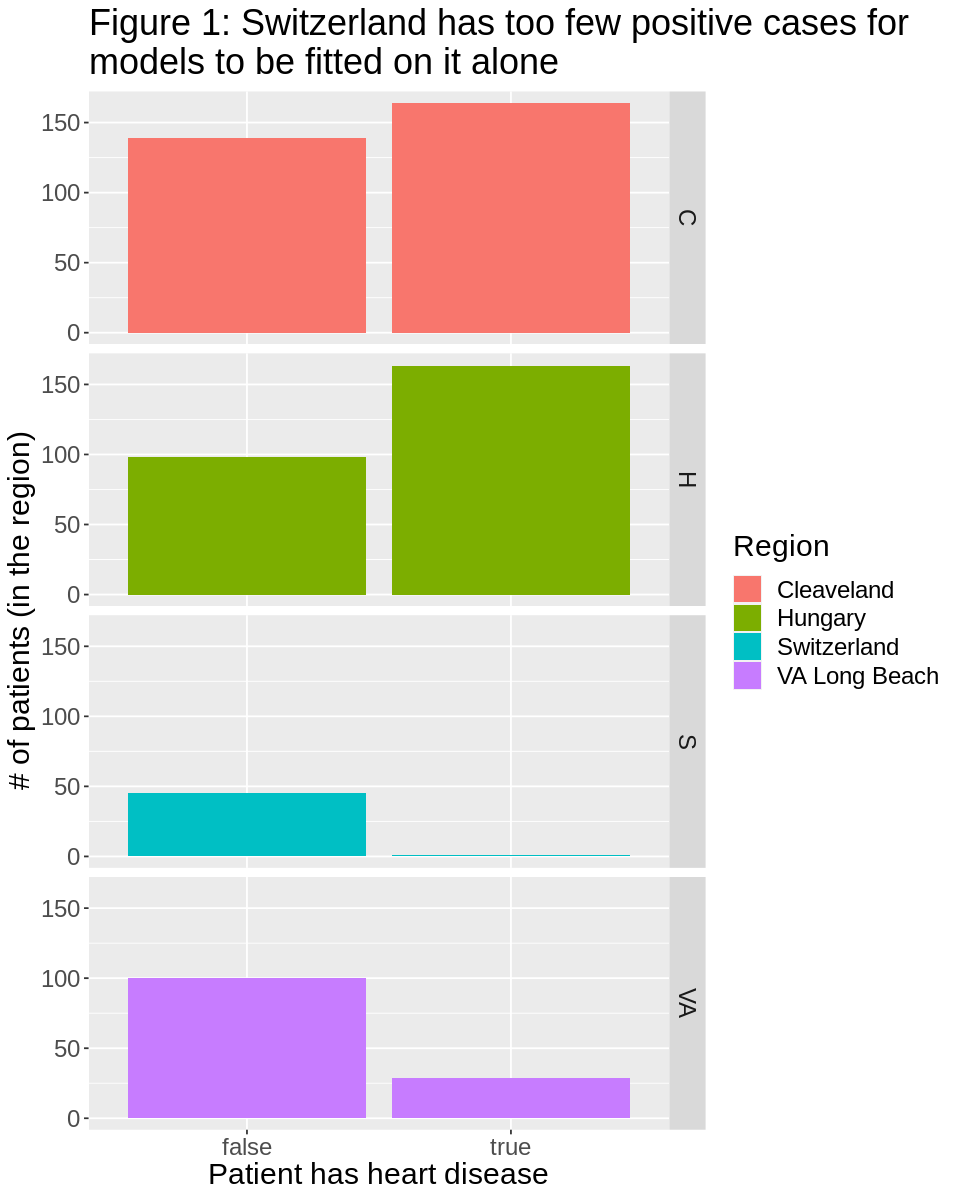

In [70]:
# Visualize distribution of positive and negative cases by region

# increase plot size
options(repr.plot.width=8, repr.plot.height=10)

# Figure 1

# print("Figure 1: VA Long Beach dataset (tidied and filtered)")
ggplot(all_data, aes(x = num, fill = region)) +
    geom_bar() +
    facet_grid(rows = vars(region)) +
    labs(x = "Patient has heart disease", y = "# of patients (in the region)", fill = "Region", title = "Figure 1: Switzerland has too few positive cases for \nmodels to be fitted on it alone") +
    scale_fill_discrete(labels = c("Cleaveland", "Hungary", "Switzerland", "VA Long Beach")) +
    theme(text = element_text(size = 18))


Figure 1 gives us a better idea of which variable will dominate the knn algorithm for each region. This visualization also reveals that we cannot make a separate model for Switzerland alone: it has just one positive case, so when split into training and testing data, one of the sets will lack any positive cases. Therefore, we will not build a separate model for Switzerland in this project.

#### Scatter plot
We plot chest pain versus thalach, and color points based on the presence of heart disease, to see if there is a correlation between these predictors and the target. Stunningly, people with chest pain type 4 (asymptomatic, i.e., they have no chest pain) appear to be most at risk of developing heart disease. One explanation for this correlation could be that people who have symptoms sufficient to warrant a medical examination and get placed on this dataset, but who lack chest pain, are at significant risk. 

This graph is the answer to a tertiary exploratory question, "Is chest pain correlated with heart disease?" Later, we will use a simplified version of our model (with two predictors) to answer the predictive version of this same question. This links our models' predictions with observed correlations, and therefore grounds them in reality.

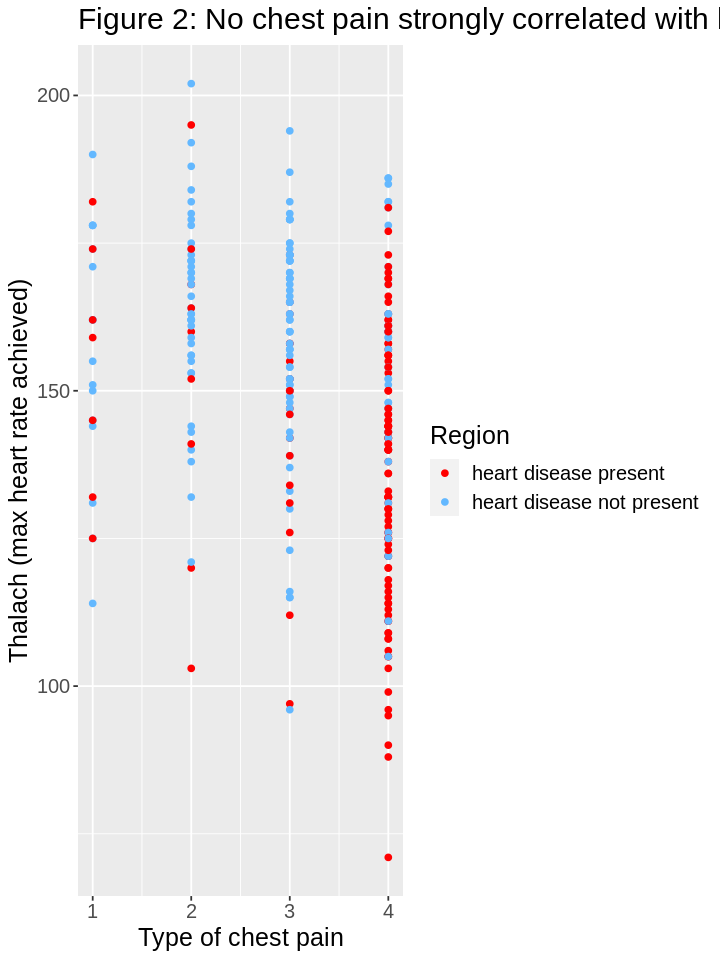

In [21]:
# Graph chest pain vs thalach colored by heart disease
# Figure 2
ggplot(cleveland_data, aes(x = cp, y = thalach, color = num)) +
    geom_point() +
    labs(x = "Type of chest pain",
         y = "Thalach (max heart rate achieved)", 
         color = "Region", 
         title = "Figure 2: No chest pain strongly correlated with heart disease") +
    scale_color_manual(labels = c("heart disease present", "heart disease not present"),
                       values = c("red1", "steelblue1")) +
    theme(text = element_text(size = 15))

### Splitting the data into training and testing sets

In this cell we split each of our regional datasets (and our combined dataset) into  training and testing sets: given the somewhat limited size of our datasets, we prioritized model accuracy over generating a more precise estimation of this model accuracy. The ratio is 75% to the training set, 25% to the testing set. The "num" column is stratified so that positive and negative cases are evenly distributed.

In [10]:
#split all the datasets into training and testing sets

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

hungarian_split <- initial_split(hungarian_data, prop = 0.75, strata = num)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

switzerland_split <- initial_split(switzerland_data, prop = 0.75, strata = num)
switzerland_train <- training(switzerland_split)
switzerland_test <- testing(switzerland_split)

va_split <- initial_split(va_data, prop = 0.75, strata = num)
va_train <- training(va_split)
va_test <- testing(va_split)

all_split <- initial_split(all_data, prop = 0.75, strata = num)
all_train <- training(all_split)
all_test <- testing(all_split)

print("Table 6: Training set for all regions combined")
all_train # Table 6

[1] "Table 6: Training set for all regions combined"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,67,C,4,1,108,160,286,0,2,1,1.5
false,67,C,4,1,129,120,229,0,2,1,2.6
false,62,C,4,0,160,140,268,0,2,0,3.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,37,VA,3,1,165,118,240,0,2,0,1
true,68,VA,3,1,151,134,254,1,0,1,0
true,51,VA,4,0,96,114,258,1,2,0,1


### Forward Selection: finding the best predictors
We write a function which performs forward selection on a training set (provided as an argument). This function then returns a tibble which lists the accuracy that results from using different combinations and numbers of predictors with the given dataframe. This table also includes the best value of K for each model. Forward selection works thusly:

Starting with no predictors "used"...
1. try adding each of the unused predictors to the model formed by the current "used" predictors in turn; evaluate the accuracy of the resulting model
2. Whichever resulting model was the most accurate becomes the new model, and the new predictor added to it is removed from the "unused" predictors
3. The process repeats until no predictors remain

A human can then choose the model with the best combination of accuracy and simplicity*

\*In the case of this project, because we do not start off with too many predictors, we use code to automatically pick the most accurate set of predictors and use it in later steps.

In [44]:
# Define a function to select best parameters for a given set of training data
# Doing this with a function makes performing forward selection on all four sets of training data much easier

# The following code was adapted for this project from Chapter 6 of "Data Science: A First Introduction" by Tiffany Timbers, Trevor Campbell, and Melissa Lee.

find_predictors <- function(df) {
#!EA rename stuff from cancer to heart disease
    
    # avoid mutating the function argument
    dataset <- df
    
    # select all numeric predictors
    names <- colnames(dataset |> select(-num,-region))

    # create an empty tibble to store the results
    accuracies <- tibble(size = integer(), 
                         model_string = character(), 
                         accuracy = numeric(),
                         k = numeric())

    # create a model specification
    knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")

    # create a 5-fold cross-validation object
    heart_vfold <- vfold_cv(dataset, v = 5, strata = num)

    # store the total number of predictors
    n_total <- length(names)

    # stores selected predictors
    selected <- c()

    # for every size from 1 to the total number of predictors
    for (i in 1:n_total) {
        # for every predictor still not added yet
        accs <- list()
        models <- list()
        ks <- list()
        for (j in 1:length(names)) {
            # create a model string for this combination of predictors
            preds_new <- c(selected, names[[j]])
            model_string <- paste("num", "~", paste(preds_new, collapse="+"))

            # create a recipe from the model string
            heart_recipe <- recipe(as.formula(model_string), 
                                    data = dataset) |>
                              step_scale(all_predictors()) |>
                              step_center(all_predictors())

            # tune the KNN classifier with these predictors, 
            # and collect the accuracy, K for the best model
            acc <- workflow() |>
              add_recipe(heart_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = heart_vfold, grid = 10) |>
              collect_metrics() |>
              filter(.metric == "accuracy") 
            
            # extract the best value of K for use later when building the actual model
            best_k <- acc |> slice_max(order_by = mean, n = 1, with_ties = FALSE) |> select(neighbors) |> pull()
            
            # Extract the accuracy for the best model
            acc <- acc |> slice_max(order_by = mean, n = 1, with_ties = FALSE) |> select(mean) |> pull() 
            
            # add this result to the dataframe
            accs[[j]] <- acc
            models[[j]] <- model_string
            ks[[j]] <- best_k
        }
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |> 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]],
                  k = ks[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }

    accuracies <- mutate(accuracies, percent_accuracy = accuracy*100)

    return(accuracies)

}
    




### Applying the function to calculate the best predictor sets
In the cell below we calculate the best set of predictors for each dataset, using the function we wrote above. The highest-accuracy set of predictors for each dataset is printed out.

In [45]:
# Run forward selection (using the function above) on each dataset we are considering (everything excluding Switzerland)
# This will take a LONG time to run. Possibly 16 minutes.

set.seed(0337187)

all_accuracy <- find_predictors(all_train)

print("25% done...") # The waiting becomes unbearable if you don't know you're making progress

cleveland_accuracy <- find_predictors(cleveland_train)

print("50% done...")

hungarian_accuracy <- find_predictors(hungarian_train)

print("75% done...") # "Are we there yet?"

va_accuracy <- find_predictors(va_train)

print("100% done! Finally!")

[1] "A"
[1] "B"
[1] "C"


We display the highest achieved accuracy values for each model, as well as the model strings that produced this accuracy, in Table 7.

In [68]:
# Produce a table with the best models and their model strings
all_accuracy_for_comb <- all_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, n = 1) |> mutate(region = "All")
cleveland_accuracy_for_comb <- cleveland_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, n = 1) |> mutate(region = "Cleveland")
hungarian_accuracy_for_comb <- hungarian_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, n = 1) |> mutate(region = "Hungary")
va_accuracy_for_comb <- va_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, n = 1) |> mutate(region = "VA Long Beach")
combined_accuracies_and_strings <- rbind(all_accuracy_for_comb,
                                         cleveland_accuracy_for_comb,
                                         hungarian_accuracy_for_comb,
                                         va_accuracy_for_comb)
print("Table 7: Best model strings and highest accuracies for each region")
combined_accuracies_and_strings



[1] "Table 7: Best model strings and highest accuracies for each region"


model_string,percent_accuracy,k,region
<chr>,<dbl>,<dbl>,<chr>
num ~ thalach+cp+exang+oldpeak+sex+restecg+chol,79.95001,3,All
num ~ thalach+cp+oldpeak+sex+exang+restecg+fbs,82.73869,15,Cleveland
num ~ cp+sex+oldpeak+chol+age+thalach,85.58097,9,Hungary
num ~ age+chol+sex+fbs+exang+restecg+cp+trestbps+oldpeak,86.47368,8,VA Long Beach


### Plotting the accuracy of different sets of predictors for each region
To confirm that we picked good choices for our predictor sets, we graph the number of predictors selected against the accuracy of each set of predictors.

In [30]:
# Define a function that plots the accuracy of a model vs the number of predictors that model uses.
plot_accuracy <- function(accur, t="UNDEFINED", num="X"){
    ggplot(accur, aes(x = size, y = percent_accuracy)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of predictors", y = "Accuracy (%)", title = paste("Figure",num,":"," Percent accuracy vs # of predictors for ",t, sep="")) +
        theme(text = element_text(size = 15)) +
        scale_x_continuous(breaks = seq(0,10, by = 1))
    }

# Make the following graphs smaller
options(repr.plot.width=6, repr.plot.height=8)

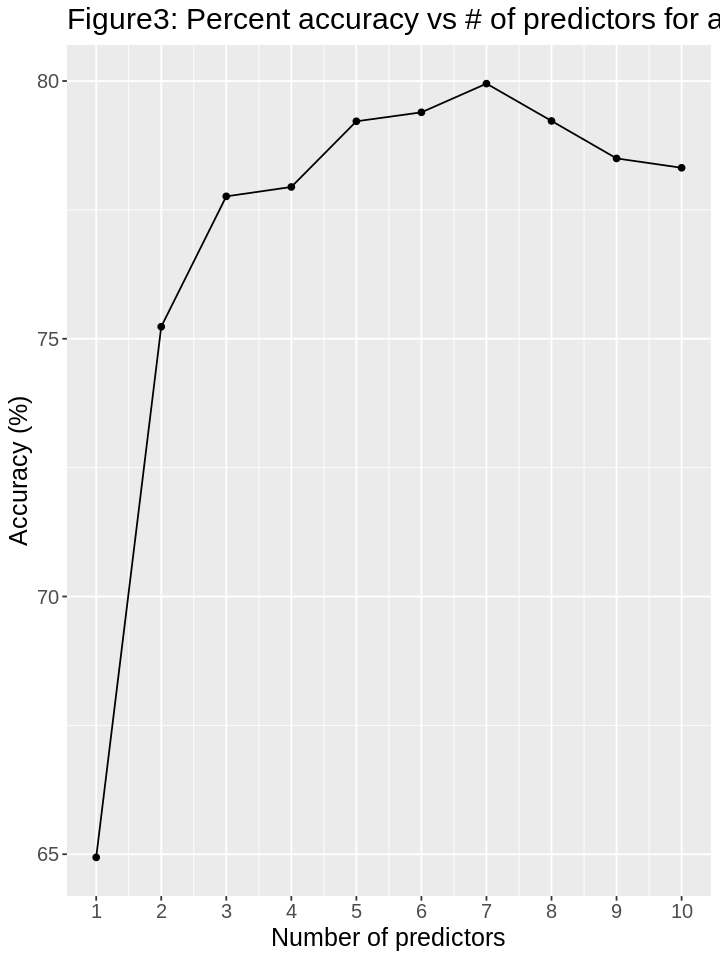

In [48]:
plot_accuracy(all_accuracy, "all regions","3")

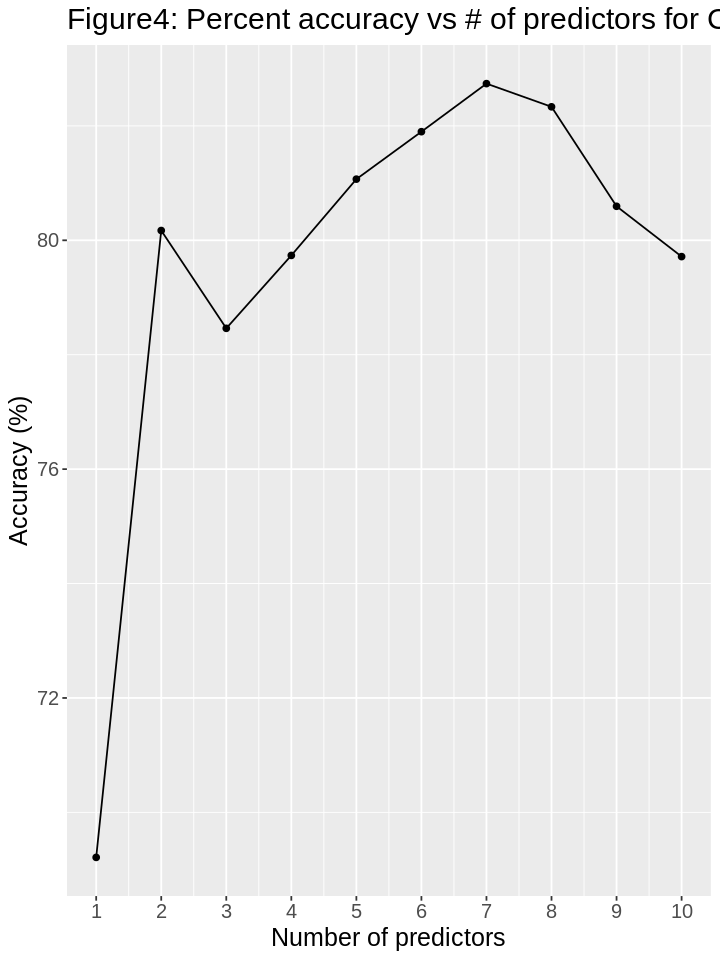

In [50]:
plot_accuracy(cleveland_accuracy, "Cleveland","4")

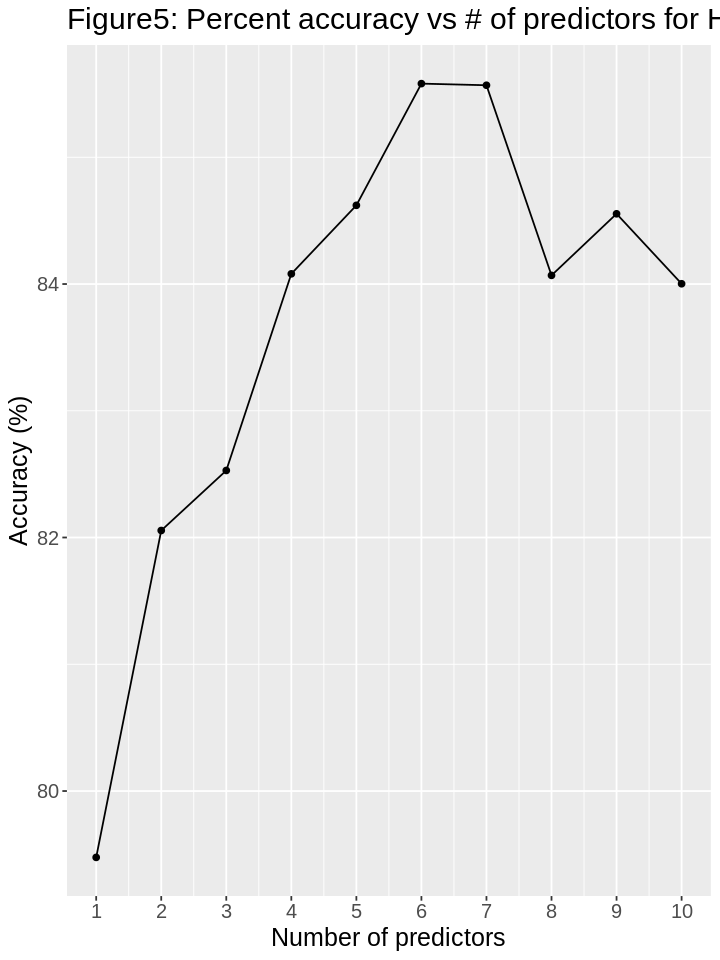

In [51]:
plot_accuracy(hungarian_accuracy, "Hungary","5")

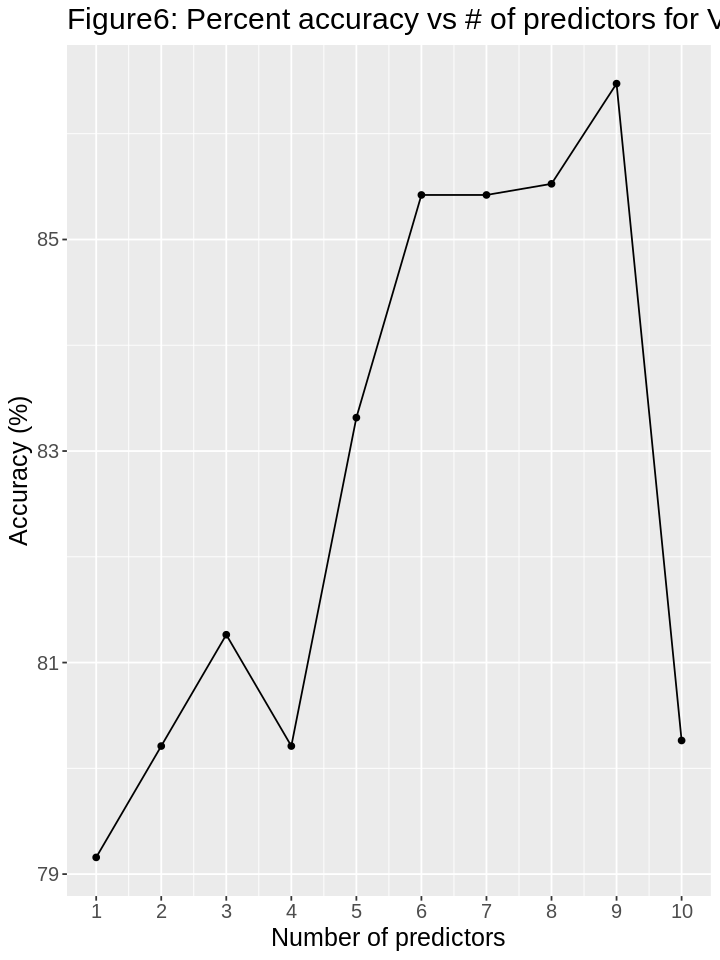

In [52]:
plot_accuracy(va_accuracy, "VA Long Beach","6")

Do note that while the textbook says to pick the "elbow" of the graph, we let our code automatically pick the model with the highest accuracy, out of concern that our relative inexperience will lead to us picking a poor elbow and compromising the accuracy of the model.

### Building the model and estimating its accuracy against the testing data
We write a function that fits a knn classification model using the best value of "k" (found during forward selection) and then estimates the accuracy with the testing set. The function returns the model's accuracy, its best value of K, and a confusion matrix for the produced model. The confusion matricies will be invaluable for getting a sense of how accurate this model is, as it cannot be easily graphed given its high dimensionality.

In [69]:
model_and_fit <- function(accuracy_df, train_df, test_df, region=""){
    # get predictors with max accuracy
    best_model <- accuracy_df |> slice_max(percent_accuracy, n = 1) 
    best_predictors <- best_model |> pull(model_string)
    best_k <- best_model |> pull(k)
    
        df_recipe <- recipe(as.formula(best_predictors), data = train_df) |> 
            step_scale(all_predictors()) |> 
            step_center(all_predictors())
    
    print(paste("The best value of K for", region, "is", best_k))
    
    df_spec_k <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> set_engine("kknn") |> set_mode("classification")
    
    df_fit <- workflow() |>
        add_recipe(df_recipe) |>
        add_model(df_spec_k) |>
        fit(data = train_df)

    df_summary <- df_fit |>
        predict(test_df) |>
        bind_cols(test_df) |>
        metrics(truth = num, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        rename(accuracy = .estimate) |>
        pull()

    df_conf_mat <- df_fit |>  predict(test_df) |>
                              bind_cols(test_df) |>
                              conf_mat(truth = num, estimate = .pred_class)
    return(c(df_summary,best_k,df_conf_mat)) # return the tuple so that I can access best_k in code later
    }

# model_and_fit(switzerland_accuracy,switzerland_train,switzerland_test, "Switzerland")[1] # Switzerland explodes for some reason, probably due to lack of data causing unexpected inputs.




#### Calculating accuracy using test dataset: All

In the cells below we call the function we wrote to estimate the accuracy of the model using the testing set. The combined dataset ends up having the best accuracy, of around 82%.

In [54]:
all_mod <- model_and_fit(all_accuracy,all_train,all_test, "all regions combined")
print("Table 8: Accuracy of the best model for all regions combined") # These steps could have been added to the function, but in this position they help serve as titles too.
all_mod[1]


[1] "The best value of K for all regions combined is 3"
[1] "Table 8: Accuracy of the best model for all regions combined"


[[1]]
[1] 0.8225806

#### Calculating accuracy using test dataset: Cleveland

In the cell below we calculate the accuracy of the best model we can make using the data specifically from Cleveland.

In [55]:
cl_mod <- model_and_fit(cleveland_accuracy,cleveland_train,cleveland_test, "Cleveland")
print("Table 10: Accuracy of the best model for Cleveland")
cl_mod[1]


[1] "The best value of K for Cleveland is 15"
[1] "Table 10: Accuracy of the best model for Cleveland"


[[1]]
[1] 0.7763158

#### Calculating accuracy using test dataset: Hungary

In the cell below we calculate the accuracy of the best model we can make using the data specifically from Hungary.

In [56]:
hu_mod <- model_and_fit(hungarian_accuracy,hungarian_train,hungarian_test, "Hungary")
print("Table 12: Accuracy of the best model for Hungary")
hu_mod[1]


[1] "The best value of K for Hungary is 9"
[1] "Table 12: Accuracy of the best model for Hungary"


[[1]]
[1] 0.6969697

#### Calculating accuracy using test dataset: VA Long Beach

In the cell below we calculate the accuracy of the best model we can make using the data specifically from VA Long Beach.

In [57]:
va_mod <- model_and_fit(va_accuracy,va_train,va_test, "VA Long Beach") 
print("Table 14: Accuracy of the best model for VA Long Beach")
va_mod[1]                                                             


[1] "The best value of K for VA Long Beach is 8"
[1] "Table 14: Accuracy of the best model for VA Long Beach"


[[1]]
[1] 0.7878788

## Visualization of the analysis
In this section we use visualization to provide a more concrete interpretation of the results of our analysis. Unfortunately, because we used more than two predictors for each of our models, they are not easily graphed. 

This being the case, the most revealing visualization we can produce is the confusion matrix for each model we generated. The confusion matrecies are shown below.



In [58]:
print("Table 9: Confusion Matrix for all regions combined")
all_mod[3]

[1] "Table 9: Confusion Matrix for all regions combined"


$table
          Truth
Prediction false true
     false    83   20
     true     13   70


In [59]:
print("Table 13: Confusion Matrix for Hungary")
hu_mod[3]

[1] "Table 13: Confusion Matrix for Hungary"


$table
          Truth
Prediction false true
     false    14    9
     true     11   32


In [60]:
print("Table 11: Confusion Matrix for Cleveland")
cl_mod[3]

[1] "Table 11: Confusion Matrix for Cleveland"


$table
          Truth
Prediction false true
     false    27    9
     true      8   32


In [61]:
print("Table 15: Confusion Matrix for VA Long Beach")
va_mod[3]

[1] "Table 15: Confusion Matrix for VA Long Beach"


$table
          Truth
Prediction false true
     false    25    7
     true      0    1


As a secondary visualization of the analysis, we make a simplified version of our model that uses only two parameters so that we can graph it and observe its predictions. We use the Cleveland dataset, as it is the largest of the regional datasets. We use the predictors cp and thalach, the first two predictors uncovered by our forward selection for this region.  

### Part 1: Find Best K for Simplified Model
In the following cell, we identify the best value of k for our simplified, two-parameter KNN model.

In [62]:
# Part 1: Best K for 2 predictors
# (Since we're unable to visualize more than 3 dimensions, we must pick only 2 predictors: I will select cp and thalach,
# which together had pretty decent accuracy results for most of the regions)

cleveland_recipe <- recipe(num ~ cp + thalach, data = cleveland_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())
 
cl_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")

cl_fold <- vfold_cv(cleveland_train, v = 10, strata = num)

cl_k_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cl_spec_tune) |>
    tune_grid(resamples = cl_fold, grid = 10) |>
    collect_metrics()

cl_best_k <- cl_k_fit |> slice_max(mean, n = 1) |> select(neighbors) |> pull()



# Interesting idea: plot the number of datapoints in a region vs the best value of K. This can be accomplished by counting the rows of each dataframe and binding these summarized tibbles.
# Make the model_and_fit function return a tuple with the accuracy value and the best value of K so that I can pull those and bind them. Or just read the values off the output.
# ggplot(

### Part 2: Fit

In the next cell, we use the calculated best value of K in a new model that is fit on the training data.

In [63]:
# Part 2: Fit
# We're viewing cleveland because it's the most accurate. (we've also then validated the choice of past ML researchers, who used the cleveland set exclusively as well)

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cl_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cleveland_spec) |>
    fit(data = cleveland_train)


### Part 3: Predict

In the following cell, we create a grid of artificial values that will be used in visualizing where a point has to fall to be classified as having heart disease or not. We predict the !EA num variable of each of these artificial values for this same purpose. This cell uses a lot of code adapted from the textbook.

In [64]:
# Part 3: Predict
# The following code was adapted for this project from Chapter 6 of "Data Science: A First Introduction" by Tiffany Timbers, Trevor Campbell, and Melissa Lee.

thal_grid <- seq(min(cleveland_train$thalach),
                 max(cleveland_train$thalach),
                 length.out = 100) # sets the desired length of the sequence
cp_grid <- seq(min(cleveland_train$cp),
                 max(cleveland_train$cp),
                 length.out = 100) # sets the desired length of the sequence
combined_grid <- as_tibble(expand.grid(thalach = thal_grid, cp = cp_grid)) # TODO !EA: figure out using the docs what CP is, put its name here

predicted_grid <- predict(cleveland_fit, combined_grid)

prediction_table <- bind_cols(predicted_grid,combined_grid) |> rename(num = .pred_class)


### Part 4: Graph
In the next cell, we plot each point of the entire Cleveland dataset with the cp variable on the x axis, and the thalach variable on the y axis of a scatterplot. The predicted grid of artificial values is plotted as well, with a large size and low alpha, as a method of visualizing which areas lead to which specific classifications. The model shows that chest pain is not only correlated with heart disease, as our pre-analysis visualisation demonstrated; chest pain predicts heart disease. We have answered both exploratory and predictive questions with this analysis.

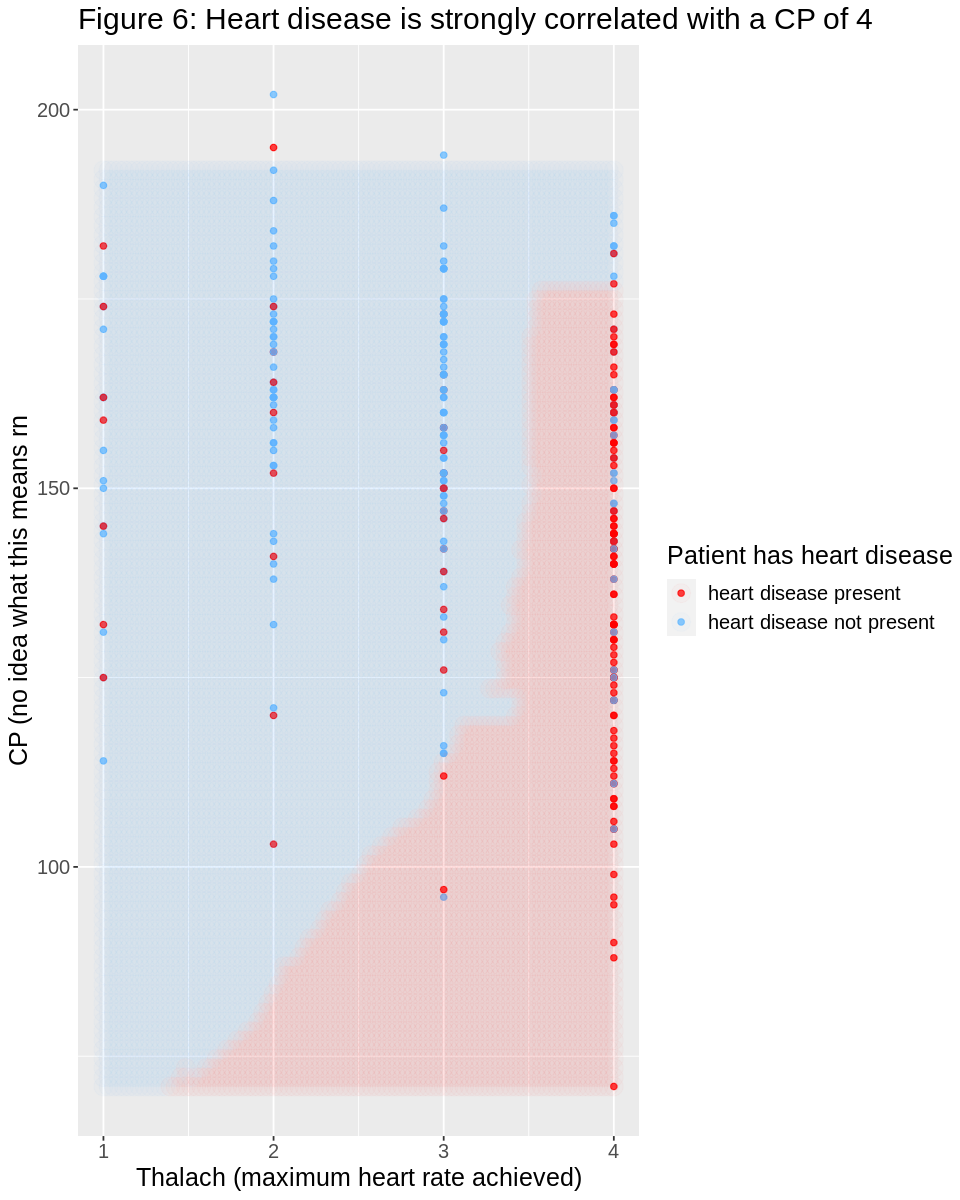

In [65]:
# Set graph dimensions
options(repr.plot.width=8, repr.plot.height=10)

# Part 4: Graph
ggplot() +
    geom_point(data = cleveland_data,
               mapping = aes(x = cp, y = thalach, color = num), alpha = 0.75) +
    geom_point(data = prediction_table,
               mapping = aes(x = cp, y = thalach, color = num), alpha = 0.02, size = 5) +
    labs(color = "Patient has heart disease",
         x = "Thalach (maximum heart rate achieved)",
         y = "CP (no idea what this means rn",
         title ="Figure 6: Heart disease is strongly correlated with a CP of 4") +
    scale_color_manual(labels = c("heart disease present", "heart disease not present"),
                       values = c("red1", "steelblue1")) +
    theme(text = element_text(size = 15))
    
    



## Methods

In order to decide what variables will be used as predictors for this model, we will employ forward selection, using the metric of accuracy. This will allow us to reliably determine, without assumptions, which variables contribute to improving the accuracy of the model and which do not. Because we have not yet done the analysis (and thus haven’t performed the forward selection yet) we cannot state which columns we will use at this time. To visualize the results, we will plot different choices of *k* for the model vs the accuracy that this choice of parameter produces. We will use this visualization to determine which choice of *k* results in the best accuracy.

## Expected Outcomes And Significance

### What do you expect to find?

With this data analysis, we would expect to find a correlation between whether or not an individual has a heart disease, and certain variables that we could use to predict it. For example, if an individual has a higher than average resting blood pressure, and higher than average cholesterol, we would expect for them to have a similarly higher chance of having a heart disease. This prediction is based on previous knowledge of heart diseases, but with our analysis we would expect to find some other factors that point to an individual having a higher or lower chance of contracting a heart disease. 

### What impact could such findings have?

These findings could allow hospitals to more accurately predict if an individual has a heart disease by attempting to classify it using our data set. It could also reduce the workload of doctors and nurses by automatically calculating how likely it is for someone to have a heart disease, which could get rid of the easy diagnoses and let doctors take over for the more difficult ones. By capturing the most impactful properties that indicate heart disease, we can also attempt to figure out methods of treatment and prevention that directly influence these properties.

### What future questions could this lead to?

This could lead to further questions about medical diagnoses from data, and if they could ever have any real life applications in the medical field. For example, based on the properties of a mole, could we predict if it is harmful or not? On the other hand, we could also ask the question of how legitimate our model is, by using a completely different heart disease data set and comparing the accuracy. Finally, as we have access to heart disease data from a variety of locations, we could ask the question: do the characteristics of heart disease remain consistent in different regions of the world? If they do not, we could try to figure out how it is different and why.